# JSC270 Class
## March 2, 2020

### Today's Class

- Survival analysis
- Unsupervised learning - hierarchical clustering

# Survival Analysis

- Outcome variable: Time until an event occurs

- Start follow-up $\overset{\text {Time}}\longrightarrow$ Event

- Event examples: death; disease; recovery; purchase.

- Time is often called survival time since it's the time that an individual has survived over some follow-up period.


# Censored Data

- Censoring occurs when we have some information about individual survival time, but it's not exactly known.

- Consider a person followed in a medical study until they die.  If the study ends while the patient is still alive then the patient's survival time is censored, since the person will die after the study ends.

- Common reasons why censoring may occur:
   + study ends - no event
   + lost to follow-up
   + withdraw from study


# Survival in Pancreas Cancer Patients - The Cancer Genome Atlas (TCGA)

![](tcga.png)

## Question: How can observed survival be defined?

`vital_status`: The survival state of the person registered on the protocol.

`days_to_last_follow_up`: The number of days between the date used for index and to the date the patient was lost to follow-up.

`days_to_death`: Number of days between the date used for index and the date from a person's date of death represented as a calculated number of days.

[*Ref*](https://docs.gdc.cancer.gov/Data_Dictionary/viewer/#?view=table-entity-list&anchor=clinical)

OK.  But, what is the date used for index?

> Absolute dates (i.e., year, month, and day) of clinical events are considered Personally Identifiable Information, and so must be converted into periods of time relative to some index date before storing the data at the GDC. 

[*Ref*](https://gdc.cancer.gov/content/selecting-common-cross-study-clinical-data-elements)

In [1]:
import pandas as pd

clinical = pd.read_table('clinical.tsv')
clinical[['days_to_last_follow_up', 'days_to_death', 'vital_status']].head()

,days_to_last_follow_up,days_to_death,vital_status
0,--,12,Dead
1,--,12,Dead
2,706,--,Alive
3,706,--,Alive
4,--,239,Dead


# Data Wrangling

- Missing values are defined as `--`.


- How can we convert to `NaN`?

In [2]:
%run clean_missing.py

   days_to_last_follow_up  days_to_death vital_status
0                     NaN           12.0         Dead
1                     NaN           12.0         Dead
2                   706.0            NaN        Alive
3                   706.0            NaN        Alive
4                     NaN          239.0         Dead


# Defining Survival Time

**Exercise:** Create a column that corresponds to survival time.

In [3]:
# define observed survival
%run survive.py

   days_to_last_follow_up  days_to_death vital_status     os
0                     NaN           12.0         Dead   12.0
1                     NaN           12.0         Dead   12.0
2                   706.0            NaN        Alive  706.0
3                   706.0            NaN        Alive  706.0
4                     NaN          239.0         Dead  239.0


# Survival Data - Define Censoring

Define event indicator for subject $i$:

$$\delta_i=
\left\{
	\begin{array}{ll}
		1  & \mbox{if death} \\
		0 & \mbox{if censored}
	\end{array}
\right. $$

# Define Censoring Indicator


In [4]:
clinical['dead'] = np.where(clinical.vital_status == 'Alive', 0, 
                            np.where(clinical.vital_status == 'Dead', 1, None))

clinical[['days_to_last_follow_up', 'days_to_death', 'vital_status', 'os', 'dead']].head()

,days_to_last_follow_up,days_to_death,vital_status,os,dead
0,NaN,12.0,Dead,12.0,1
1,NaN,12.0,Dead,12.0,1
2,706.0,NaN,Alive,706.0,0
3,706.0,NaN,Alive,706.0,0
4,NaN,239.0,Dead,239.0,1


# Survivor Function

- Let $T \ge 0$ be a random variable for a person's survival time.


- $P(T>t)$ is called the survivor function.


- Recall that the cumulative distribution function (CDF) $F(t)$ is defined as: 

$$F(t)=P(T \le t).$$

- A common distribution for modelling survival times is the exponential distribution $\exp(\lambda)$. It has pdf and CDF:

$$f(t) =\lambda \exp(-\lambda t), t >0, \lambda >0,\\
  F(t) = \int_{0}^t f(u)du = 1-\exp(-\lambda t)$$.

- The survivor function is: $S(t)=P(T>t)= 1- F(t)=\exp(-\lambda t)$.

- A plot of the survivor function when $\lambda =1/2$ is:


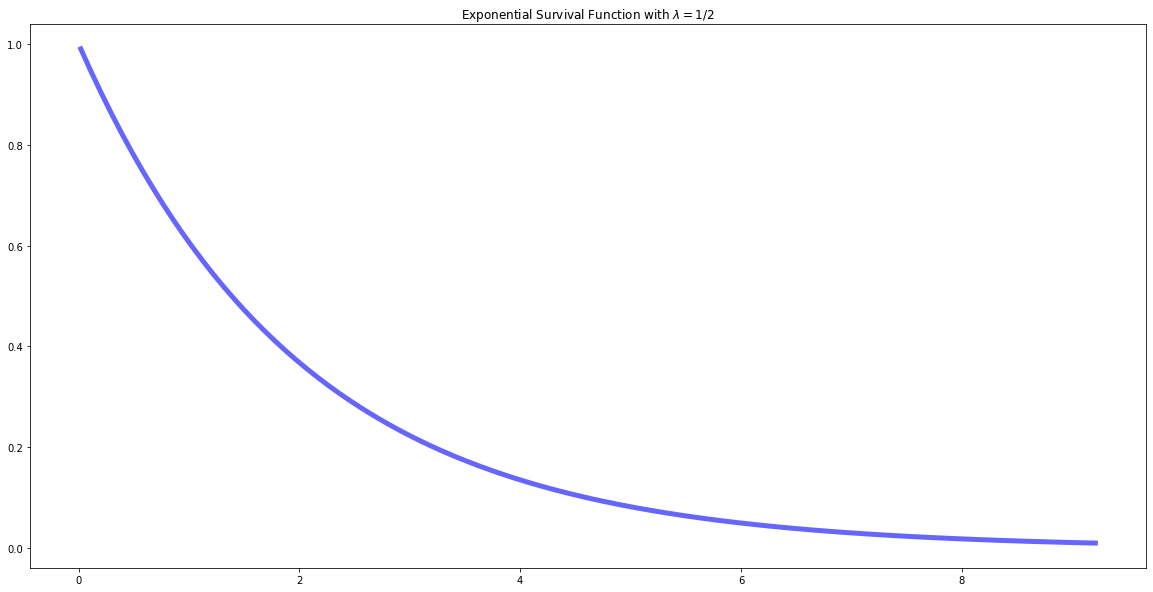

In [5]:
from scipy.stats import expon
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
x = np.linspace(expon.ppf(0.01,loc = 0, scale = 1/(1/2)), expon.ppf(0.99,loc = 0, scale = 1/(1/2)), 100)
plt.plot(x, 1- expon.cdf(x,loc = 0, scale = 1/(1/2)),'b-', lw=5, alpha=0.6)
plt.title(r'Exponential Survival Function with $\lambda = 1/2$');

- Observed survival function and exponential survival with $\lambda=1/2$.

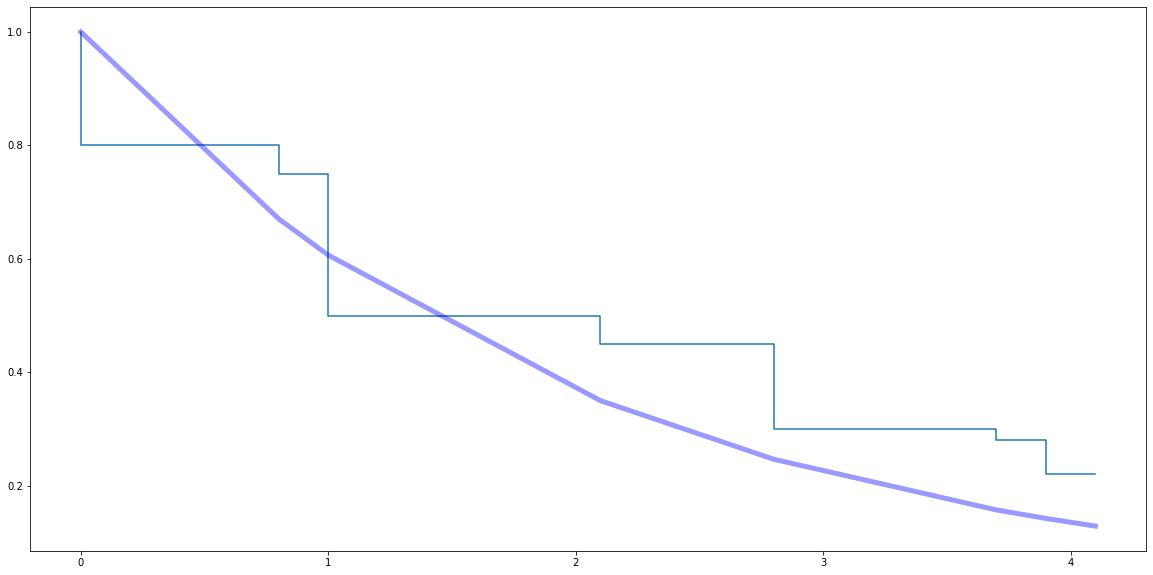

In [6]:
plt.figure(figsize=(20,10))
y = np.array([1, 0.8, 0.75, 0.5, 0.45, 0.3, 0.28, 0.22])
x = np.array([0, 0.8, 1, 2.1, 2.8, 3.7, 3.9, 4.1])
plt.step(x,y)
plt.plot(x, 1- expon.cdf(x,loc = 0, scale = 1/(1/2)),'b-', lw=5, alpha=0.4);

# Non-parametric Estimation of the Survival Function

$$\hat S(t) = \frac{\text{Number of individuals with survival times} > t}{\text{Number of individuals in data set at time } t}.$$

## The Kaplan-Meier estimator of $\hat S(t)$.  

- Consider time points $t_0, t_1,t_2, t_3,t_4,$ where $t_0$ denotes the beginning of the study.


- $\hat S(t_1) = P(T>t_1)$


- $P(T>t_1)=P(T \ge t_1)P(T>t_1|T \ge t_1)$, since, if $A={T \ge t_1}, B={T > t_1}$ and using $P(A\cap B)=P(A)P(B|A)$ with $A \cap B = B.$


- $\{T \ge t_1\} = \{T > t_0\}$ (why?), so 


- $\hat S(t_1)= P(T>t_1)=P(T>t_0)P(T>t_1|T \ge t_1)= \hat S(t_0) P(T>t_1|T \ge t_1).$


- Iterating, we have: $\hat S(t_{j})= \prod_{k=1}^j P(T>t_k|T \ge t_k)$

In [7]:
import warnings
warnings.filterwarnings('ignore')

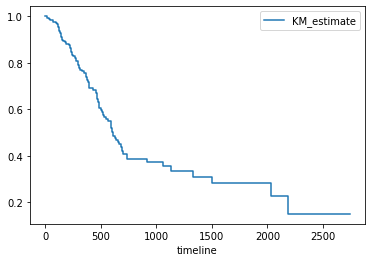

In [8]:
from lifelines import KaplanMeierFitter

# remove missing values from dataframe
clin_km = clinical[['os','dead', 'gender']].dropna()

kmf = KaplanMeierFitter()
kmf.fit(clin_km['os'], event_observed=clin_km['dead'])  
kmf.plot_survival_function(ci_show=False);

In [9]:
from lifelines.utils import survival_table_from_events

# survival table
table = survival_table_from_events(clin_km['os'], event_observed=clin_km['dead'])
eventab = table.head(n=10) 
eventab.reset_index(inplace=True) # save index as column

# km estimates
survtab = kmf.fit(clin_km['os'], event_observed=clin_km['dead']).survival_function_.head(n=10)
survtab.reset_index(inplace=True)
eventab.merge(survtab, left_on='event_at', right_on='timeline').drop(['timeline'], axis=1)

,event_at,removed,observed,censored,entrance,at_risk,KM_estimate
0,0.0,0,0,0,352,352,1.000000
1,4.0,2,0,2,0,352,1.000000
2,7.0,2,0,2,0,350,1.000000
3,8.0,2,0,2,0,348,1.000000
4,9.0,2,0,2,0,346,1.000000
5,12.0,2,2,0,0,344,0.994186
6,31.0,2,2,0,0,342,0.988372
7,33.0,2,0,2,0,340,0.988372
8,41.0,2,2,0,0,338,0.982524
9,66.0,2,2,0,0,336,0.976675


**exercise:** calculate the KM estimate at time 31.

# Comparing Kaplan-Meier Curves

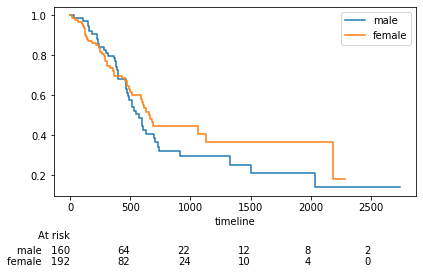

In [10]:
from lifelines.plotting import add_at_risk_counts

male = (clin_km['gender'] == 'male')
female = (clin_km['gender'] == 'female')

f1 = KaplanMeierFitter()
f1.fit(clin_km['os'][~male], event_observed=clin_km['dead'][~male], label = 'male')  
ax = f1.plot(ci_show=False)

f2 = KaplanMeierFitter()
f2.fit(clin_km['os'][~female], event_observed=clin_km['dead'][~female], label = 'female')  
ax = f2.plot(ax=ax, ci_show=False)

add_at_risk_counts(f1, f2);

# Log-Rank Test

**Question:** Are Kaplan-Meier (KM) curves statistically different?

This corresponds to a null hypothesis $H_0:$ The KM curves are equivalent, and an alternative hypothesis $H_A:$ The KM curves are different.

The log-rank test is based on a chi-square test.

At time $j$ we have the $2 \times 2$ table:

| Group | Survive         | Die      |  Total        |
|-------|-----------------|----------|----------|
| I     | $$n_{1j}-d_{1j}$$ | $d_{1j}$ | $n_{1j}$ |
| II    | $$n_{2j}-d_{2j}$$ | $d_{2j}$ | $n_{2j}$ |
| Total      |  $$n_j-d_j$$    |   $d_{j}$  | $n_j$     |

The log-rank is a statistical test for an association between the rows (Groups) and columns (Survival) across all the time points. 

# `lifelines.statistics.logrank_test`


Compare KM survival curves between males and females.

In [11]:
from lifelines.statistics import logrank_test

clin_km[clin_km['gender']=='male']['os']

results = logrank_test(clin_km[clin_km['gender']=='male']['os'], 
                       clin_km[clin_km['gender']=='female']['os'], 
                       event_observed_A = clin_km[clin_km['gender']=='male']['dead'], 
                       event_observed_B = clin_km[clin_km['gender']=='female']['os'])
results.print_summary()

**Question:** Interpret the p-value from the log-rank test.

# Hierarchical Clustering

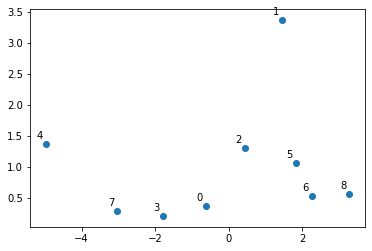

In [12]:
# Generate random data
np.random.seed(6)
X1 = np.random.normal(0,2,9)
X2 = np.random.normal(0,1,9) + np.random.uniform(0,1,9)
X3 = np.array((X1, X2)).T
plt.scatter(X1, X2)
labels = range(0, 9)

# label the points
for label, x, y in zip(labels, X1[:,], X2[:,]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

**Question:** Are there groups/clusters of points in the scatterplot? 

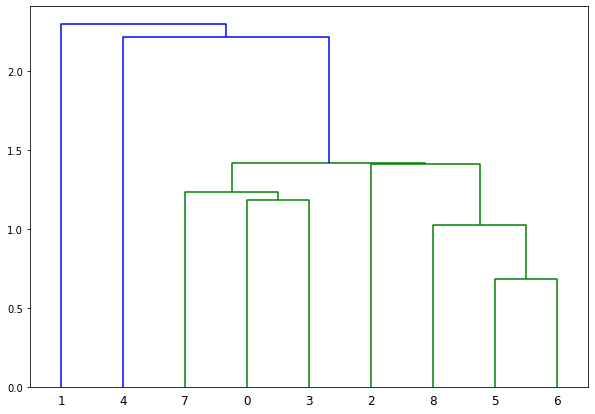

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X3, 'single')

labelList = range(0, 9)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

# Hierarchical Clustering Algorithm

1. Begin with $n$ observations and a measure (such as Euclidean distance) of all the 􏰁${n \choose 2} = n(n − 1)/2$ pairwise dissimilarities. Treat each observation as its own cluster.


2. For $i=1,\ldots,n$:

(a) Examine all pairwise inter-cluster dissimilarities among the $i$ clusters and identify the pair of clusters that are least dissimilar (that is, most similar). Fuse these two clusters. The dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion should be placed.

(b) Compute the new pairwise inter-cluster dissimilarities among the $i − 1$ remaining clusters.

# Interpreting the Dendogram


- Observations 5 and 6 are similar to each other, since they fuse at the lowest point on the dendogram. 


- Observations 0 and 3 are also similar to each other.


- It is tempting but incorrect to conclude from the figure that observations 1 and 4 are quite similar to each other on the basis that they are located near each other on the dendrogram.  


- The similarity of two observations is based on the location on the vertical axis where branches containing those two observations first are fused.

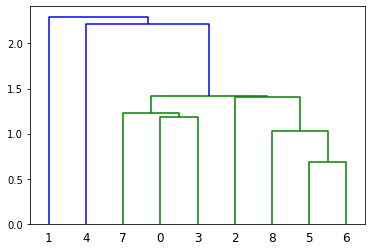

In [14]:
linked = linkage(X3, 'single')

labelList = range(0, 9)

dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [15]:
linked = linkage(X3, 'single')
linked

array([[ 5.        ,  6.        ,  0.68596879,  2.        ],
       [ 8.        ,  9.        ,  1.0248863 ,  3.        ],
       [ 0.        ,  3.        ,  1.18645962,  2.        ],
       [ 7.        , 11.        ,  1.23314849,  3.        ],
       [ 2.        , 10.        ,  1.41178825,  4.        ],
       [12.        , 13.        ,  1.4152873 ,  7.        ],
       [ 4.        , 14.        ,  2.21997246,  8.        ],
       [ 1.        , 15.        ,  2.29682047,  9.        ]])

- `linkage()` uses calculates the distances of the clusters (starting with 9 data points) as singleton clusters). 


- In each iteration merge the two clusters which have the smallest distance according Euclidean distance. 


- At the $i^{th}$ iteration clusters with indicies `linked[i,0]` and `linked[i,1]` are combined to form a cluster.


- If `index` $\ge$ $n$ then the `index` refers to the cluster formed in `linkage[index-n]`.

In [16]:
linked = linkage(X3, 'single')
linked

array([[ 5.        ,  6.        ,  0.68596879,  2.        ],
       [ 8.        ,  9.        ,  1.0248863 ,  3.        ],
       [ 0.        ,  3.        ,  1.18645962,  2.        ],
       [ 7.        , 11.        ,  1.23314849,  3.        ],
       [ 2.        , 10.        ,  1.41178825,  4.        ],
       [12.        , 13.        ,  1.4152873 ,  7.        ],
       [ 4.        , 14.        ,  2.21997246,  8.        ],
       [ 1.        , 15.        ,  2.29682047,  9.        ]])

*For example:*

- Cluster 0: `linked[0,]` indicates clusters with index 5 and 6 are merged to form one cluster.


- Cluster 1: `linked[1,]` indicates clusters with index 8 and 0 are merged to form one cluster.

In [17]:
from scipy.spatial.distance import euclidean

print('data: \n',X3,'\n \n', 
      'Euclidean dists:',euclidean(X3[5],X3[6]),euclidean(X3[5],X3[8]), euclidean(X3[8],X3[6]) )

data: 
 [[-0.62356735  0.37227696]
 [ 1.45800785  3.3676872 ]
 [ 0.43564158  1.310954  ]
 [-1.79818359  0.20505524]
 [-4.9735613   1.36256202]
 [ 1.82650304  1.06877546]
 [ 2.25412745  0.53240755]
 [-3.02818646  0.29307877]
 [ 3.27858217  0.56214769]] 
 
 Euclidean dists: 0.6859687867971159 1.5379224565496714 1.0248863043766658


### Question: How do we determine if a cluster should be fused with another cluster?

### Answer: Linkage defines the dissimilarity between two groups of observations.

- Four common types of linkage are: complete, average, single, and centroid.


- Single linkage means compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the smallest of these dissimilarities.


- See [ISLR (chapter 10.3) page 395](http://faculty.marshall.usc.edu/gareth-james/ISL/) for descriptions of other types of linkage.

# Cut The Dendogram 

- Determine cluster labels for each observation associated with a given cut of the dendogram.

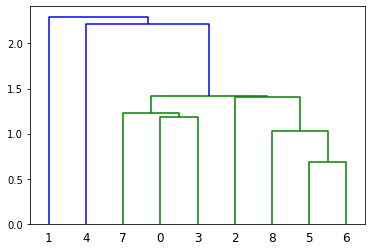

In [18]:
linked = linkage(X3, 'single')
labelList = range(0, 9)


dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [19]:
from scipy.cluster.hierarchy import cut_tree
from numpy import ogrid

num_clus = 4
clust = cut_tree(linked, n_clusters = num_clus)

tab = np.concatenate((clust, X3, ogrid[0:9,0:9][0]), axis=1)

pd.DataFrame({'cluster':tab[:,0],'point':tab[:,3], 'X1':tab[:,1],'X2':tab[:,2]})



,cluster,point,X1,X2
0,0.0,0.0,-0.623567,0.372277
1,1.0,1.0,1.458008,3.367687
2,2.0,2.0,0.435642,1.310954
3,0.0,3.0,-1.798184,0.205055
4,3.0,4.0,-4.973561,1.362562
5,2.0,5.0,1.826503,1.068775
6,2.0,6.0,2.254127,0.532408
7,0.0,7.0,-3.028186,0.293079
8,2.0,8.0,3.278582,0.562148


# Plot the Classification

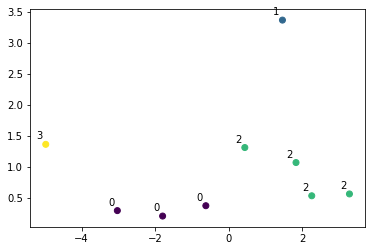

In [20]:
clust = cut_tree(linked, n_clusters = num_clus).T[0].tolist() 
plt.scatter(X1,X2, c = clust)
for label, x, y in zip(clust, X1[:,], X2[:,]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

# Finding Clusters in RNA Expression

- RNA expression data is avalable for each subject in the study in a directory

In [21]:
import glob
# get list of file names
genefilenames = glob.glob('gdc_download_20200125_191127.229504/**/*.gz', recursive = True)
print('number of gene files:',len(genefilenames))
generna = genefilenames[0]
generna

number of gene files: 182


'gdc_download_20200125_191127.229504/b2d8c11f-7d98-4899-8780-0ac83feb3fa8/05f0ced5-6976-4f43-9be5-fddb3f550adf.FPKM.txt.gz'

# RNA Expression Data

- The number of genes for each patient in the study is shown below.
- Transform the RNA expression values using $f(x)=ln(x+1).$
- Main question of lab: Can you identify distinct groups (biological “subtypes”) of patients with pancreas cancer, using The Cancer Genome Atlas (TCGA) transcriptome sequencing data, that have different survival times?

In [22]:
genedat = pd.read_csv(generna, sep = '\t', header = None, names = ['gene', 'rna'] )

# transform rna values 

genedat['logrna'] = genedat['rna'].transform(lambda x: np.log(x+1))
print(genedat.count())
genedat.head()

gene      60483
rna       60483
logrna    60483
dtype: int64


,gene,rna,logrna
0,ENSG00000242268.2,0.024500,0.024205
1,ENSG00000270112.3,0.000000,0.000000
2,ENSG00000167578.15,3.446283,1.492069
3,ENSG00000273842.1,0.000000,0.000000
4,ENSG00000078237.5,2.209606,1.166148


In [23]:
from scipy.special import comb
#print(comb(9,2))

from scipy.spatial.distance import pdist, squareform
#pdist(X3)
squareform(pdist(X3))

array([[0.        , 3.64766196, 1.4152873 , 1.18645962, 4.46129039,
        2.54714646, 2.88214662, 2.40592299, 3.90676615],
       [3.64766196, 0.        , 2.29682047, 4.53927567, 6.7368842 ,
        2.32825769, 2.94493075, 5.43867229, 3.34447945],
       [1.4152873 , 2.29682047, 0.        , 2.4925864 , 5.40944906,
        1.41178825, 1.97813687, 3.61028733, 2.93990171],
       [1.18645962, 4.53927567, 2.4925864 , 0.        , 3.37977004,
        3.72617308, 4.06551157, 1.23314849, 5.08930895],
       [4.46129039, 6.7368842 , 5.40944906, 3.37977004, 0.        ,
        6.80640769, 7.2752073 , 2.21997246, 8.29087058],
       [2.54714646, 2.32825769, 1.41178825, 3.72617308, 6.80640769,
        0.        , 0.68596879, 4.91627049, 1.53792246],
       [2.88214662, 2.94493075, 1.97813687, 4.06551157, 7.2752073 ,
        0.68596879, 0.        , 5.28773283, 1.0248863 ],
       [2.40592299, 5.43867229, 3.61028733, 1.23314849, 2.21997246,
        4.91627049, 5.28773283, 0.        , 6.31250573],
